<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/non_neural_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [ ]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

Mounted at /gdrive


In [ ]:
from functions import *
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the data

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
300892,kapital,marx,communism,Since the great mass of the Hindu population a...,Since the great mass of the Hindu population a...,288,since the great mass of the hindu population a...,since the great mass of the hindu population ...,"['Since', 'the', 'great', 'mass', 'of', 'the',..."
84131,complete works vol 2,aristotle,aristotle,"or, thirdly, shall some employments be assigne...","or, thirdly, shall some employments be assigne...",88,"or, thirdly, shall some employments be assigne...","or , thirdly , shall some employment be assig...","['or', ',', 'thirdly', ',', 'shall', 'some', '..."
132531,analysis of mind,russell,analytic,"And finally there is St. Paul's, which is the ...","And finally there is St. Paul's, which is the ...",69,"and finally there is st. paul's, which is the ...","and finally there be St. Paul 's , which be t...","['And', 'finally', 'there', 'is', 'St.', 'Paul..."
192104,madness and civilization,foucault,continental,His day is nothing but the most superficial ni...,His day is nothing but the most superficial ni...,65,his day is nothing but the most superficial ni...,-PRON- day be nothing but the most superficia...,"['His', 'day', 'is', 'nothing', 'but', 'the', ..."
151145,papers vol 1,lewis,analytic,"As materialists, we want to characterize pain ...","As materialists, we want to characterize pain ...",71,"as materialists, we want to characterize pain ...","as materialist , -PRON- want to characterize ...","['As', 'materialists', ',', 'we', 'want', 'to'..."


In [ ]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ['“','”','...',"''",'’','``', "'", "‘"]
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 'us',
                    'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 'hyl', 'phil', 'one'] + stopwords_list

### Baseline NB Bayes Model

In [ ]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [ ]:
# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [ ]:
# build the classifier, train it, get predictions
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

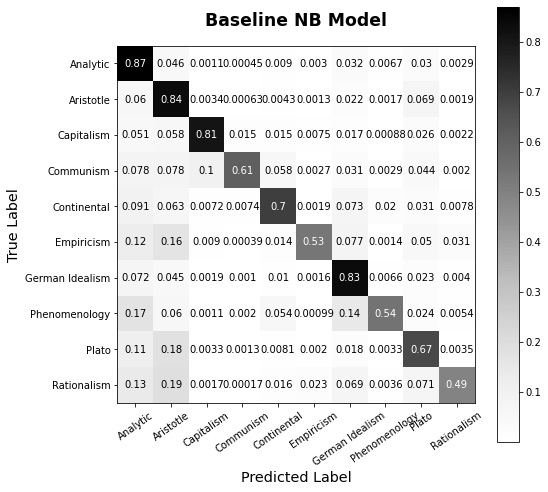

In [ ]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, y_test, title='Baseline NB Model')

In [ ]:
print(classification_report(y_test, nb_classifier_preds))

                 precision    recall  f1-score   support

       analytic       0.64      0.87      0.74     13380
      aristotle       0.63      0.84      0.72     12654
     capitalism       0.84      0.81      0.83      4536
      communism       0.94      0.61      0.73      4490
    continental       0.83      0.70      0.76      8502
     empiricism       0.90      0.53      0.67      5111
german_idealism       0.72      0.83      0.77     10615
  phenomenology       0.90      0.54      0.68      7086
          plato       0.69      0.67      0.68      9684
    rationalism       0.87      0.49      0.63      5754

       accuracy                           0.72     81812
      macro avg       0.80      0.69      0.72     81812
   weighted avg       0.76      0.72      0.72     81812



Accuracy in the low 70s over 10 classes is not too bad, but we can at least aim higher than this. If we look at it, a lot of failures were along the lines of lines of class imbalance. 

In [ ]:
df['school'].value_counts(normalize=True)

analytic           0.164210
aristotle          0.154805
german_idealism    0.129243
plato              0.117242
continental        0.103653
phenomenology      0.087522
rationalism        0.070287
empiricism         0.062262
capitalism         0.055769
communism          0.055008
Name: school, dtype: float64

Perhaps correcting for class imbalance could improve the model. 

### NB Corrected for Class Imbalance

Here we will use imblearn's over and undersampler to correct for class imbalance.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [ ]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# to use the sampler, the data must be numerical
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# # get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

#### Oversampling

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='all')

In [ ]:
x_under, y_under = ros.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
nb_undersampled = MultinomialNB()
nb_undersampled.fit(x_under, y_under)
nb_undersampled_preds = nb_undersampled.predict(tf_idf_data_test)

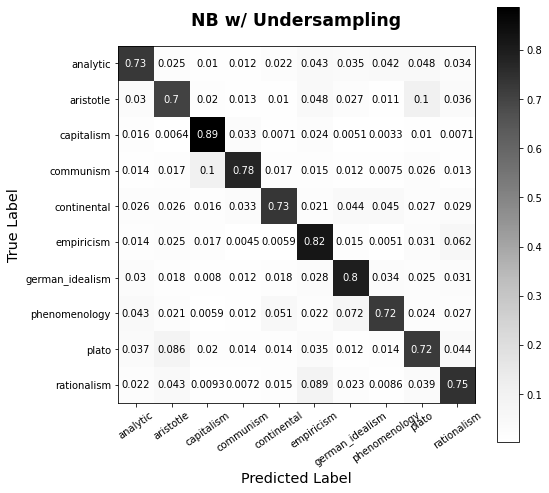

In [ ]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Undersampling', label_dict=flipped_dict)

In [ ]:
print(classification_report(y_test, nb_undersampled_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     13261
           1       0.80      0.70      0.75     12618
           2       0.74      0.89      0.80      4514
           3       0.75      0.78      0.76      4544
           4       0.82      0.73      0.78      8549
           5       0.60      0.82      0.69      5094
           6       0.80      0.80      0.80     10625
           7       0.75      0.72      0.74      7277
           8       0.69      0.72      0.71      9622
           9       0.63      0.75      0.68      5708

    accuracy                           0.75     81812
   macro avg       0.74      0.76      0.75     81812
weighted avg       0.76      0.75      0.75     81812



Not bad, we got a 2% or so increase in accuracy. Let's check if oversampling helps any more.

#### Undersampling

In [ ]:
rus = RandomUnderSampler(sampling_strategy='all')

In [ ]:
x_over, y_over = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
nb_oversampled = MultinomialNB()
nb_oversampled.fit(x_under, y_under)
nb_oversampled_preds = nb_oversampled.predict(tf_idf_data_test)

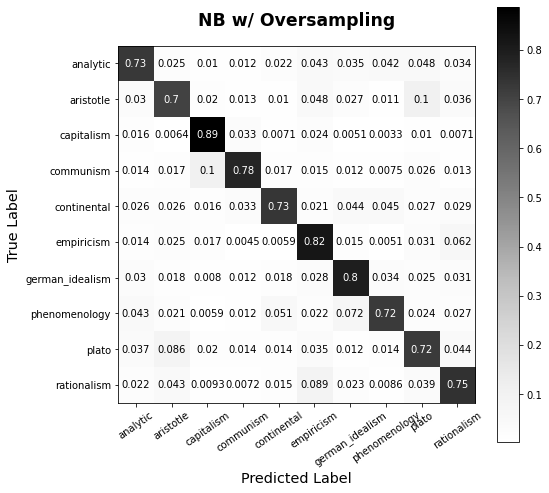

In [ ]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Oversampling', label_dict=flipped_dict)

In [ ]:
print(classification_report(y_test, nb_oversampled_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     13261
           1       0.80      0.70      0.75     12618
           2       0.74      0.89      0.80      4514
           3       0.75      0.78      0.76      4544
           4       0.82      0.73      0.78      8549
           5       0.60      0.82      0.69      5094
           6       0.80      0.80      0.80     10625
           7       0.75      0.72      0.74      7277
           8       0.69      0.72      0.71      9622
           9       0.63      0.75      0.68      5708

    accuracy                           0.75     81812
   macro avg       0.74      0.76      0.75     81812
weighted avg       0.76      0.75      0.75     81812



Unsurprisingly, not much of a different result. It seems like Multinomial Naive Bayes can give us about 75% accuracy. 

It's perhaps worth checking if lemmatization can help the model.

### NB with Lemmatization

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_str'], df['school'])

# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [ ]:
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))
flipped_dict = {value:key for key, value in label_dict.items()}

# get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [ ]:
rus = RandomUnderSampler(sampling_strategy='all')

x_over_lemma, y_over_lemma = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


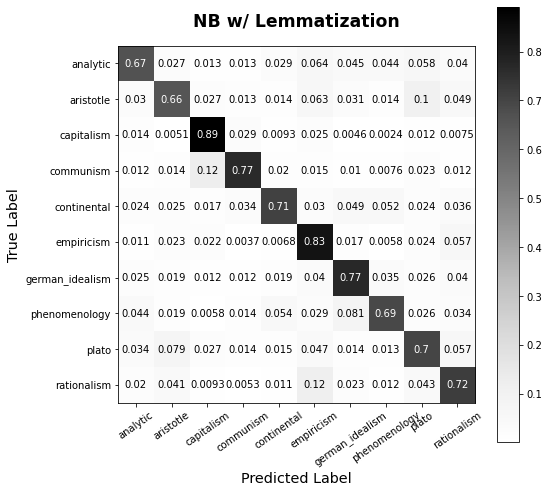

In [ ]:
nb_lemma = MultinomialNB()
nb_lemma.fit(x_over_lemma, y_over_lemma)
nb_lemma_preds = nb_lemma.predict(tf_idf_data_test)

plot_pretty_cf(nb_lemma, tf_idf_data_test, y_test, 
               title='NB w/ Lemmatization', label_dict=flipped_dict)

In [ ]:
print(classification_report(y_test, nb_lemma_preds))

              precision    recall  f1-score   support

           0       0.84      0.67      0.74     13584
           1       0.80      0.66      0.72     12697
           2       0.69      0.89      0.78      4528
           3       0.75      0.77      0.76      4486
           4       0.80      0.71      0.75      8519
           5       0.53      0.83      0.65      5167
           6       0.77      0.77      0.77     10361
           7       0.73      0.69      0.71      7126
           8       0.67      0.70      0.69      9661
           9       0.57      0.72      0.64      5683

    accuracy                           0.72     81812
   macro avg       0.71      0.74      0.72     81812
weighted avg       0.74      0.72      0.72     81812



Not great, and worse than non-lemmatized versions. This makes sense since lemmatization essentially masks information that might have had some small part to play in the classification math.